In [1]:
import flowcode
import processing
import res_flow_vis as visual

import torch
import numpy as np

In [2]:
#Filename associated with this specific run
filename = "testrun_massfixed2"

In [3]:
#Initiate a processor to handle data
mpc = processing.Processor_cond(N_min=500, percentile2=95)

In [4]:
#Load raw data
Data, N_stars, M_stars, M_dm = mpc.get_data("all_sims")

In [5]:
#Clean data
Data_const, N_stars_const, M_stars_const, M_dm_const = mpc.constraindata(Data, M_dm)

Cut out 4 of 95 galaxies, 2075359 of 34878379 stars (~6%).


In [6]:
#Choose device
device = "cuda:5"

In [7]:
#Hyperparameters of the flow
LAYER_TYPE = flowcode.NSF_CL2
N_LAYERS = 8
COND_INDS = np.array([10])
DIM_COND = COND_INDS.shape[0]
DIM_NOTCOND = Data_const[0].shape[1] - DIM_COND
SPLIT = 0.5
K = 8
B = 3
BASE_NETWORK = flowcode.MLP
BASE_NETWORK_N_LAYERS = 4
BASE_NETWORK_N_HIDDEN = 16
BASE_NETWORK_LEAKY_RELU_SLOPE = 0.2

SPLIT = {"split":SPLIT} if LAYER_TYPE == flowcode.NSF_CL else {}

In [8]:
#Instantiate the model
model = flowcode.NSFlow(N_LAYERS, DIM_NOTCOND, DIM_COND, LAYER_TYPE, **SPLIT, K=K, B=B, network=BASE_NETWORK, network_args=(BASE_NETWORK_N_HIDDEN,BASE_NETWORK_N_LAYERS,BASE_NETWORK_LEAKY_RELU_SLOPE))
model = model.to(device)

In [9]:
#Training hyperparameters
N_EPOCHS = 58
INIT_LR = 0.0000065
GAMMA = 0.99996
BATCH_SIZE = 1024
LOG_LEARN = np.array([10])

In [10]:
#Prepare data for flow
Data_flow = mpc.Data_to_flow(mpc.diststack(Data_const), LOG_LEARN)

In [11]:
#Save relevant data to the drive for external python file (device needs to be GPU) to do the training in background...
torch.save(Data_flow, "cond_trainer/data_cond_trainer.pth")
torch.save(model, "cond_trainer/model_cond_trainer.pth")
np.save("cond_trainer/params_cond_trainer.npy", np.append(COND_INDS,np.array([N_EPOCHS,INIT_LR,BATCH_SIZE,GAMMA])))
np.save("cond_trainer/filename_cond_trainer.npy", filename)

In [11]:
#...OR train here
import time
train_loss_saver = []
start = time.perf_counter()
flowcode.train_flow(model, Data_flow, COND_INDS, N_EPOCHS, lr=INIT_LR, batch_size=BATCH_SIZE, loss_saver=train_loss_saver, gamma=GAMMA)
end = time.perf_counter()
torch.save(model.state_dict(), f"saves/{filename}.pth")
np.save(f"saves/loss_{filename}.npy",np.array(train_loss_saver+[end-start]))

Step 0 of 96103, Loss:15.320651054382324, lr=1.2e-05
Step 100 of 96103, Loss:15.162898693084717, lr=1.199160264550614e-05
Step 200 of 96103, Loss:15.104810962677002, lr=1.1983211167309152e-05
Step 300 of 96103, Loss:15.081479892730712, lr=1.1974825561296929e-05
Step 400 of 96103, Loss:14.978699340820313, lr=1.196644582336023e-05
Step 500 of 96103, Loss:14.950024223327636, lr=1.1958071949392702e-05
Step 600 of 96103, Loss:14.882977638244629, lr=1.1949703935290855e-05
Step 700 of 96103, Loss:14.8168581199646, lr=1.1941341776954079e-05
Step 800 of 96103, Loss:14.777614822387696, lr=1.1932985470284627e-05
Step 900 of 96103, Loss:14.732463665008545, lr=1.192463501118762e-05
Step 1000 of 96103, Loss:14.617176685333252, lr=1.191629039557105e-05
Step 1100 of 96103, Loss:14.557916221618653, lr=1.1907951619345766e-05
Step 1200 of 96103, Loss:14.508257198333741, lr=1.189961867842548e-05
Step 1300 of 96103, Loss:14.481361656188964, lr=1.189129156872677e-05
Step 1400 of 96103, Loss:14.4014475059509

KeyboardInterrupt: 

In [14]:
#Load in training results:
model.load_state_dict(torch.load(f"saves/{filename}.pth"))
loss_results = np.load(f"saves/loss_{filename}.npy")
loss_results, tot_time = loss_results[:-1], loss_results[-1]/60

In [15]:
#Get a sample from the flow

#Set a condition for the sample
condition = mpc.diststack(Data_const)[:,COND_INDS]

#Get sample
flow_sample = mpc.galaxysplit(mpc.sample_to_Data(mpc.sample_Conditional(model, COND_INDS, condition, device=device)), N_stars_const)

In [1]:
### Visualize data

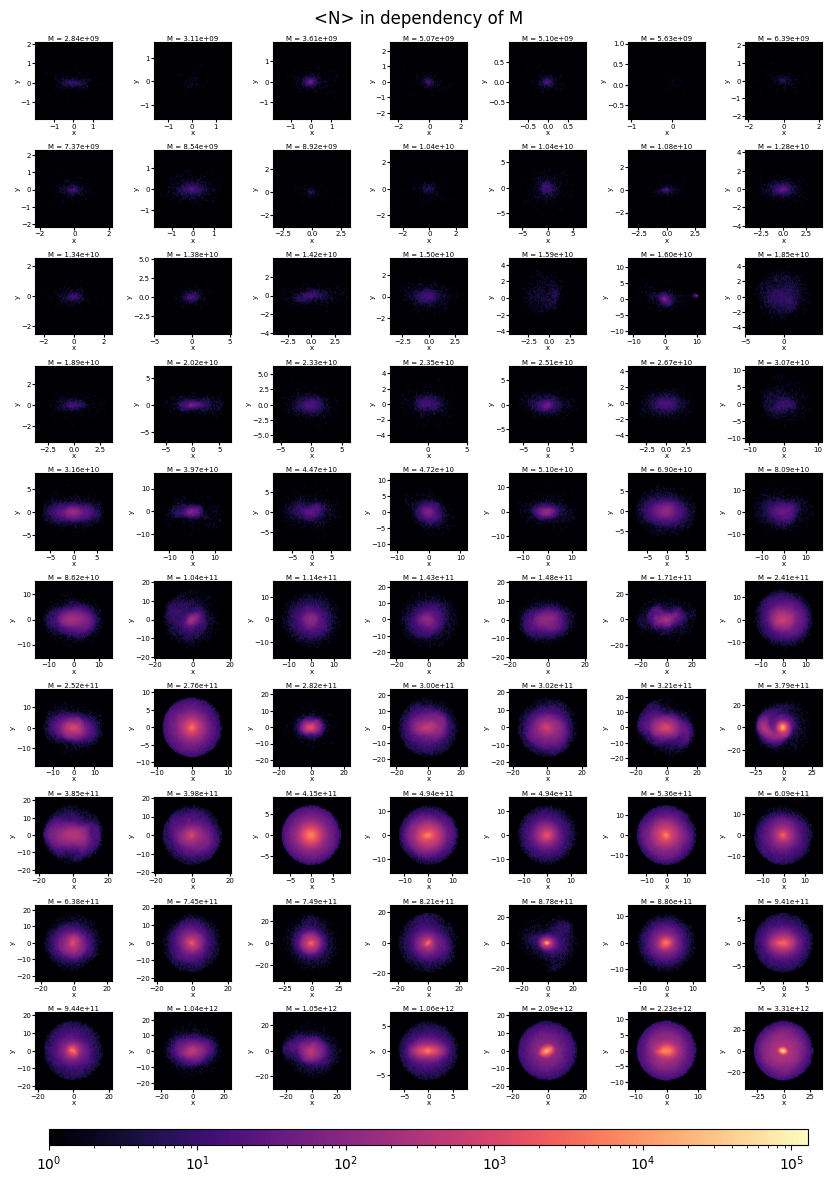

In [16]:
#Get multiple galaxy plot (data)
vs_data = visual.plot_conditional(Data_const, M_dm_const+M_stars_const, type="N", label=filename+"_data")

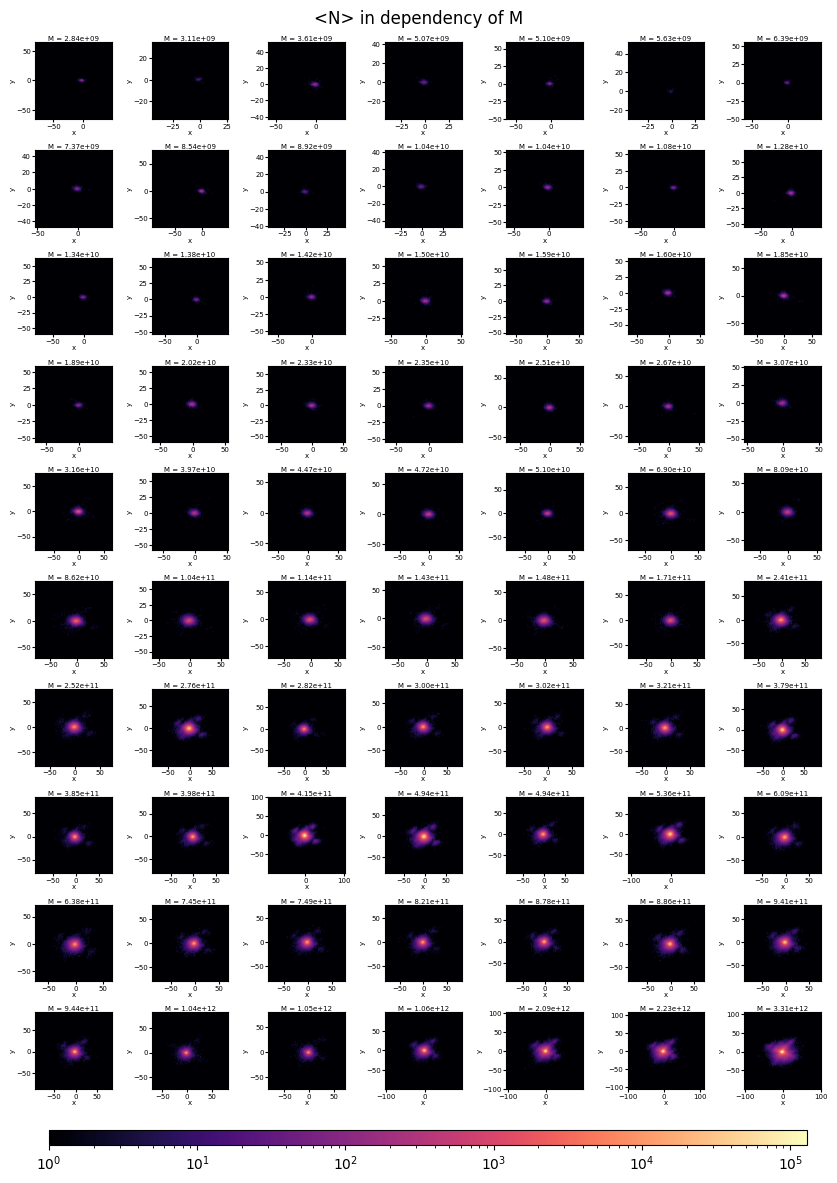

In [17]:
#Get multiple galaxy plot (sample)
visual.plot_conditional(flow_sample, M_dm_const+M_stars_const, type="N", label=filename, v_pre=vs_data)

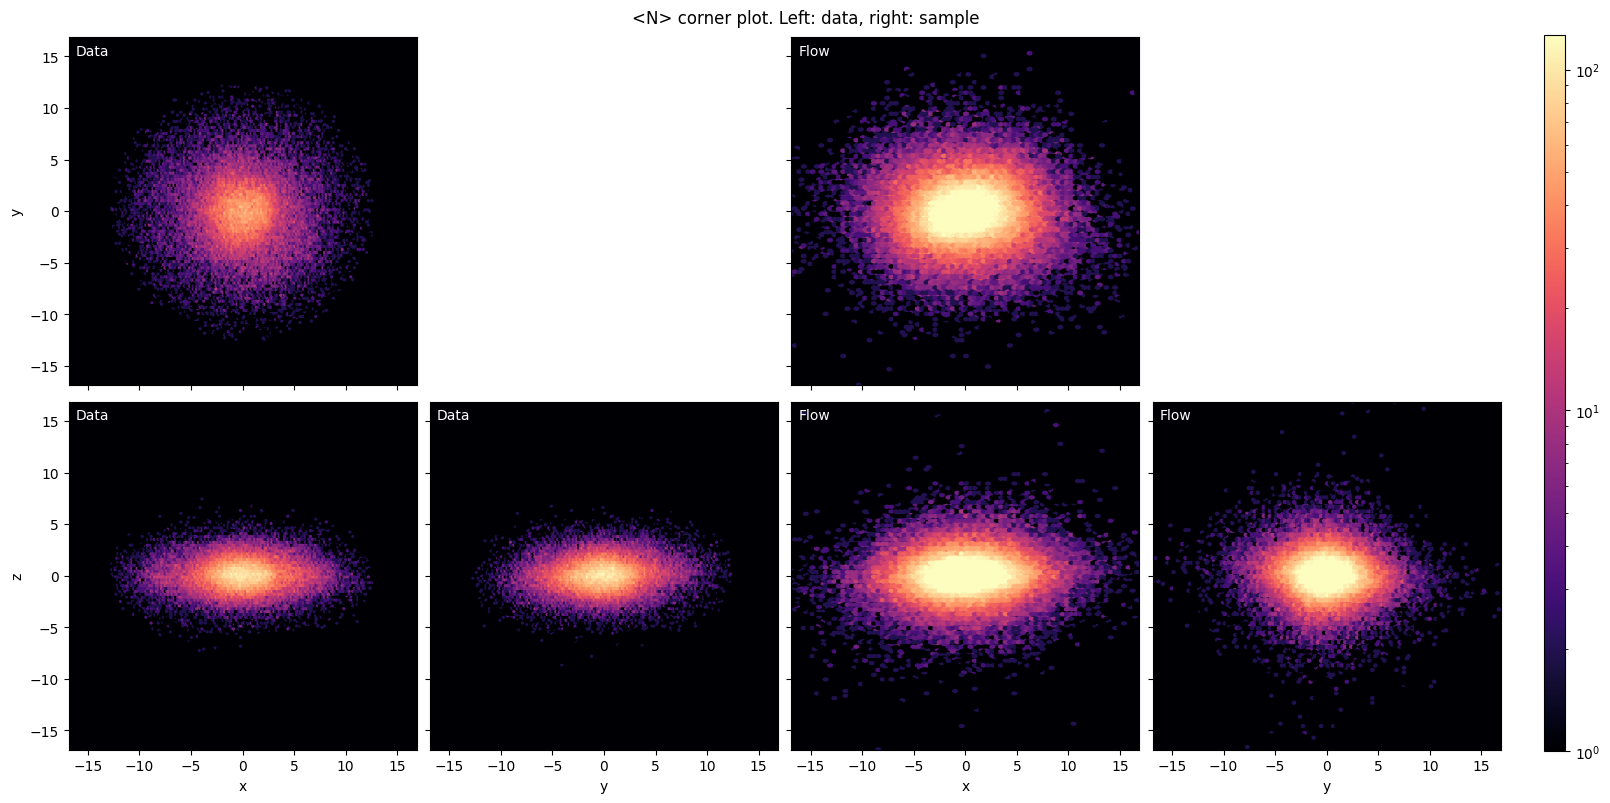

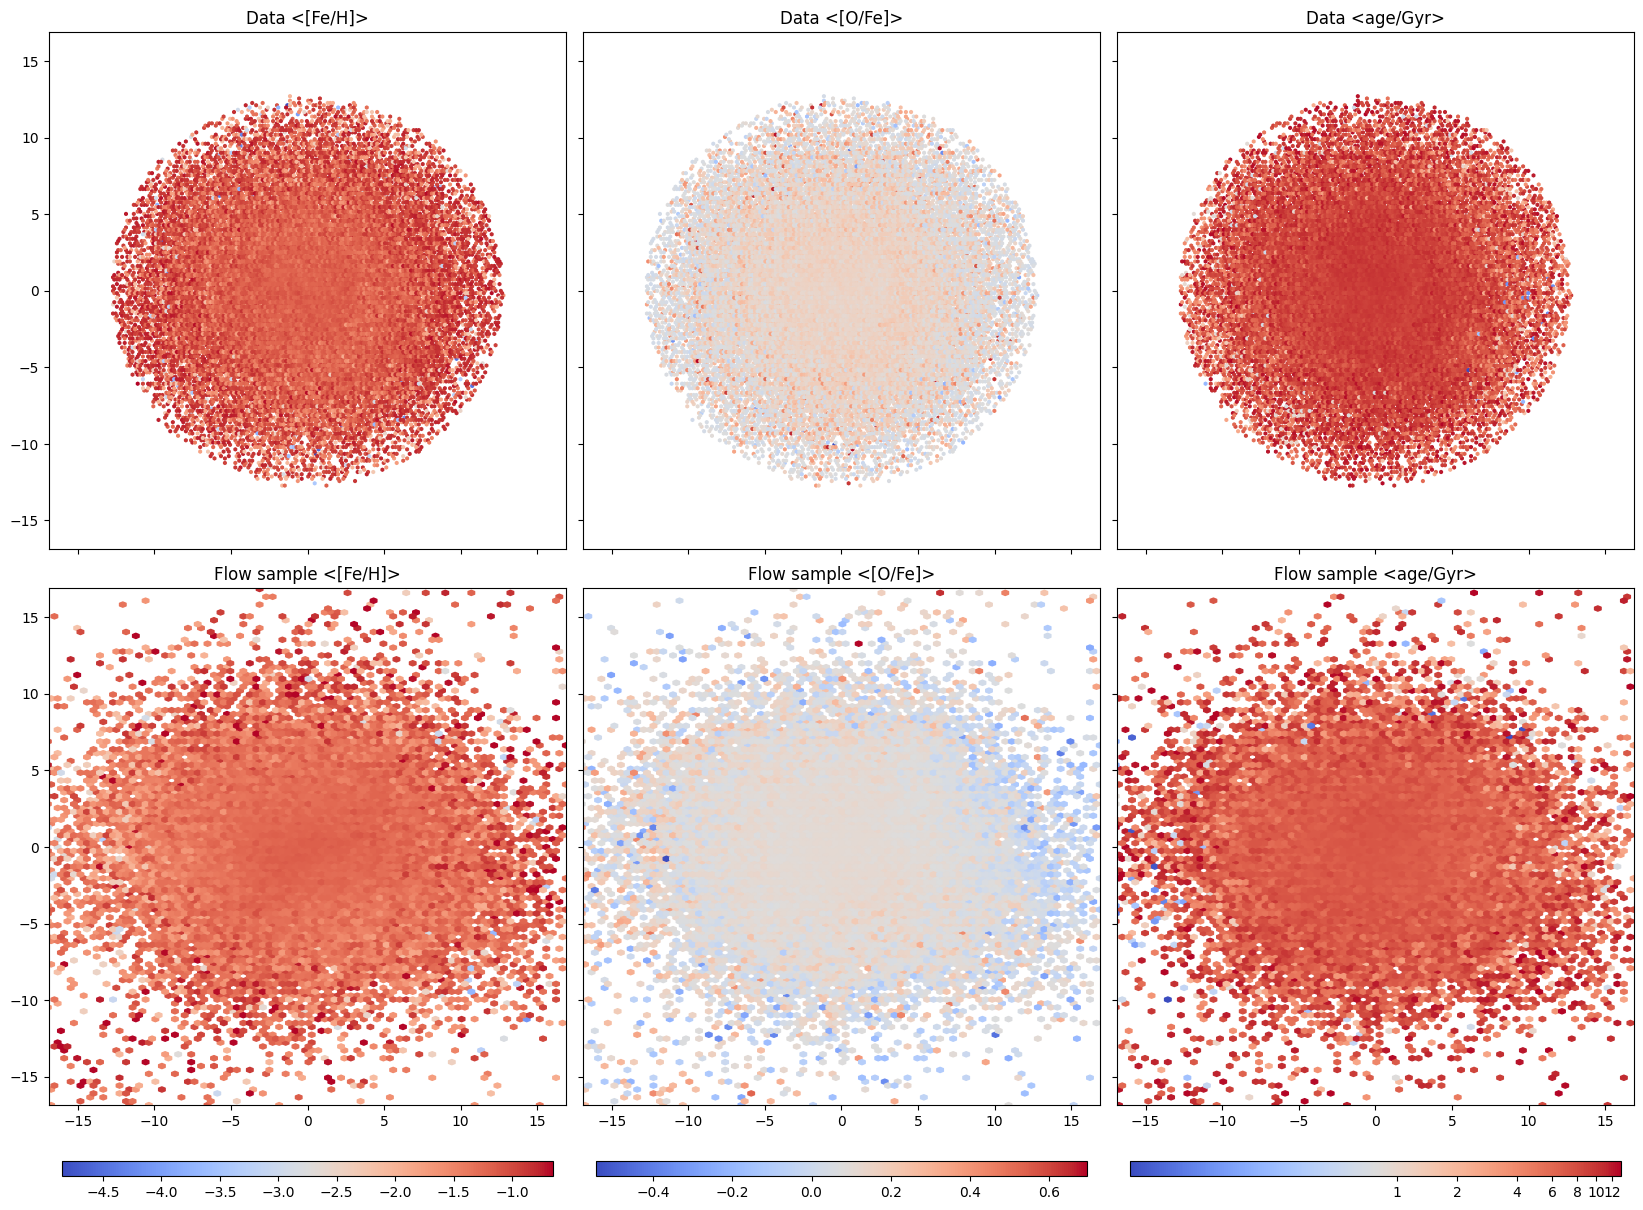

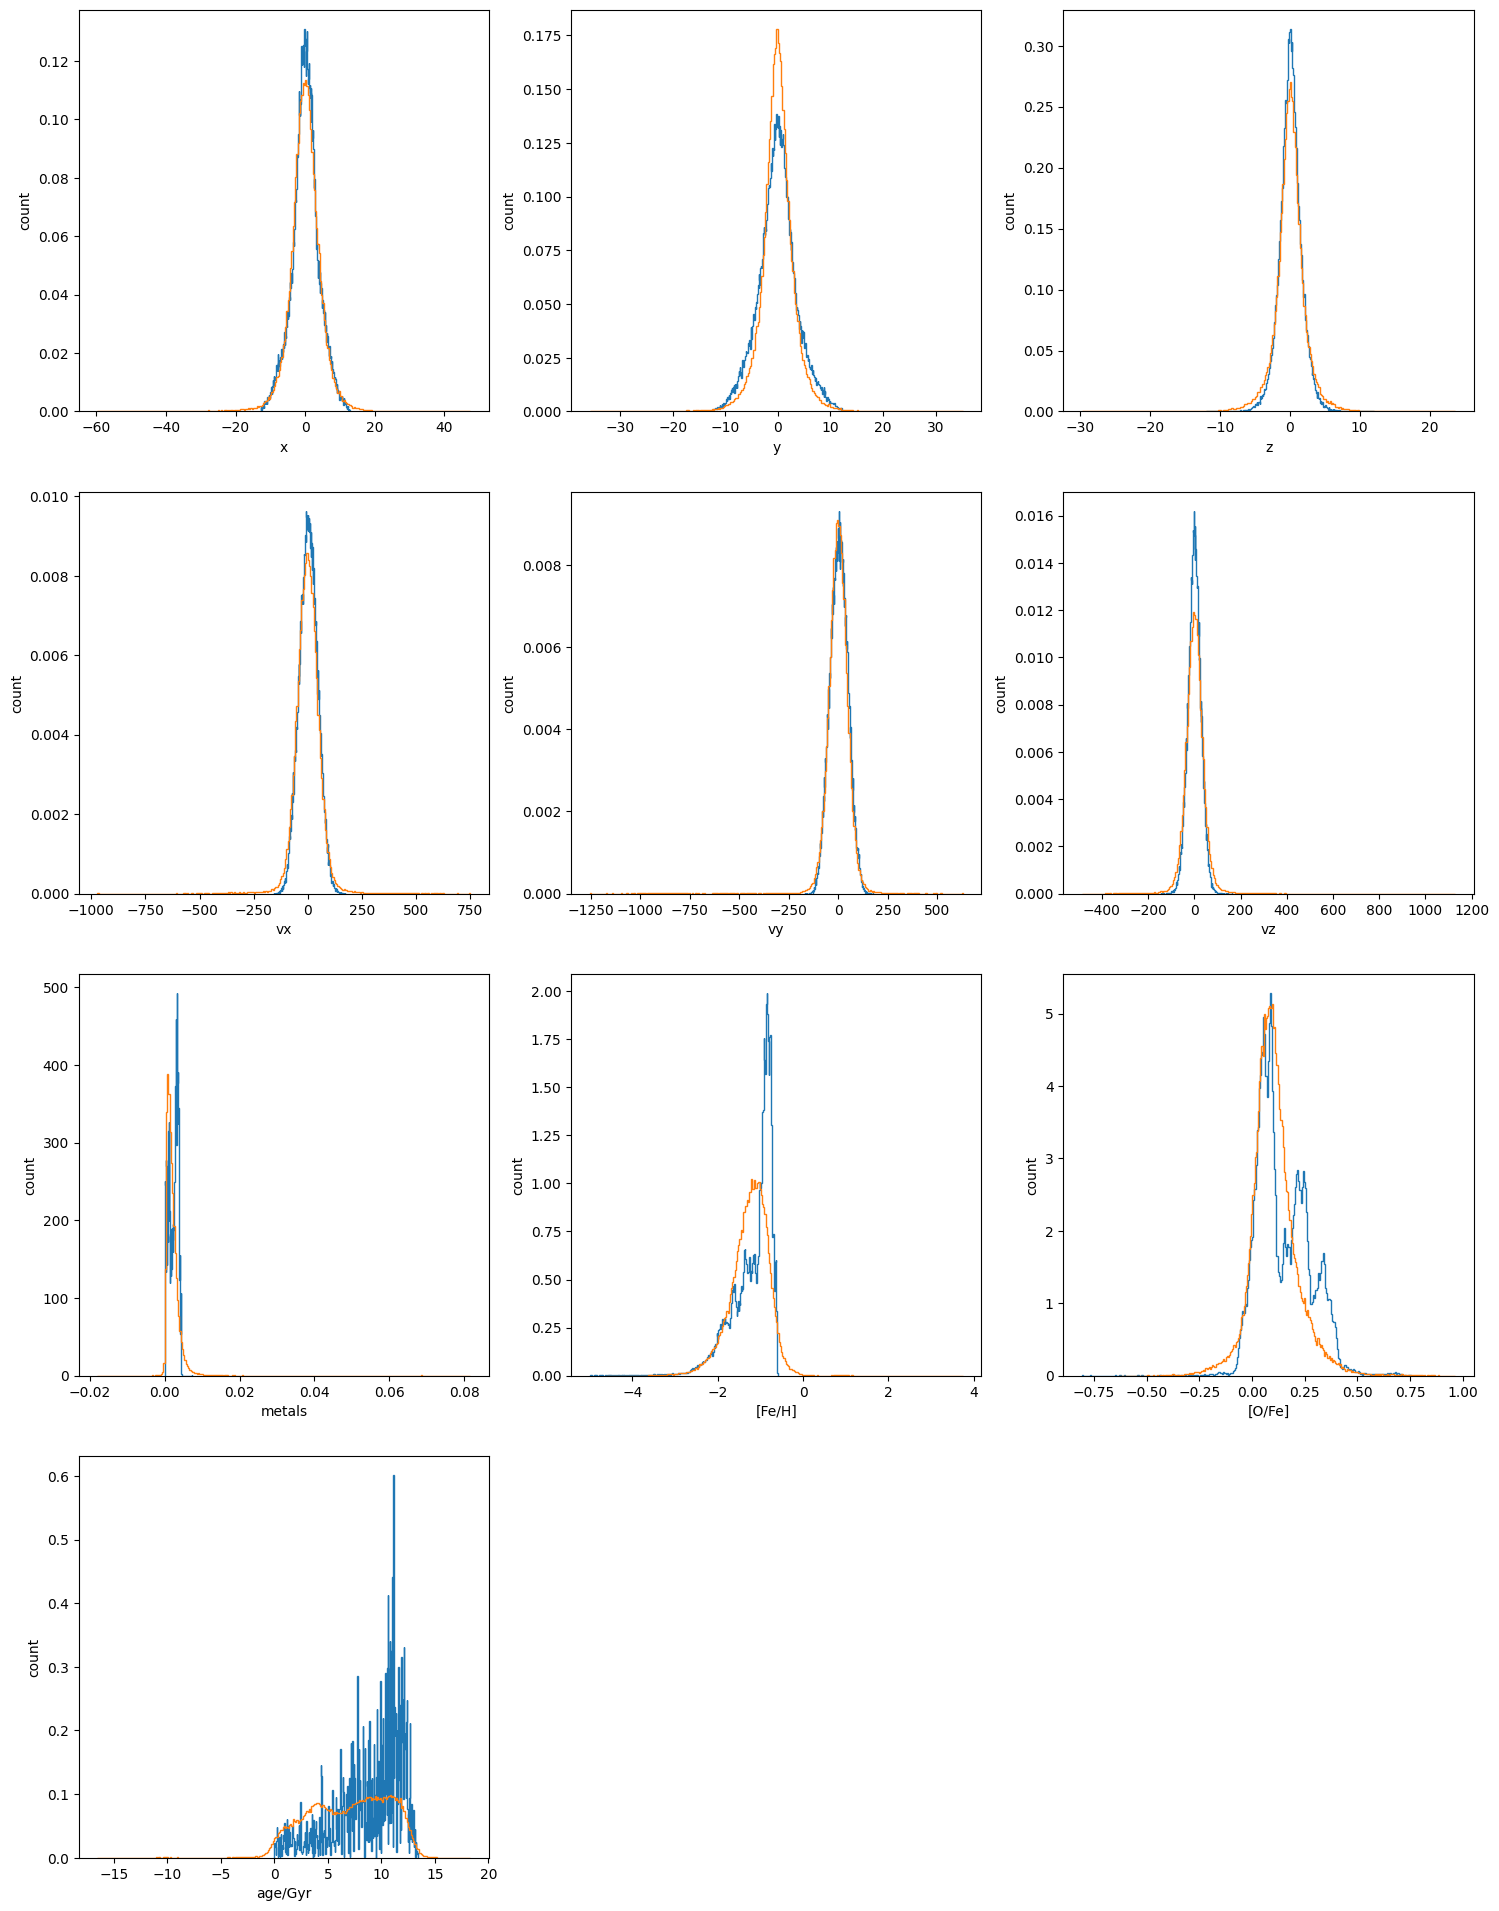

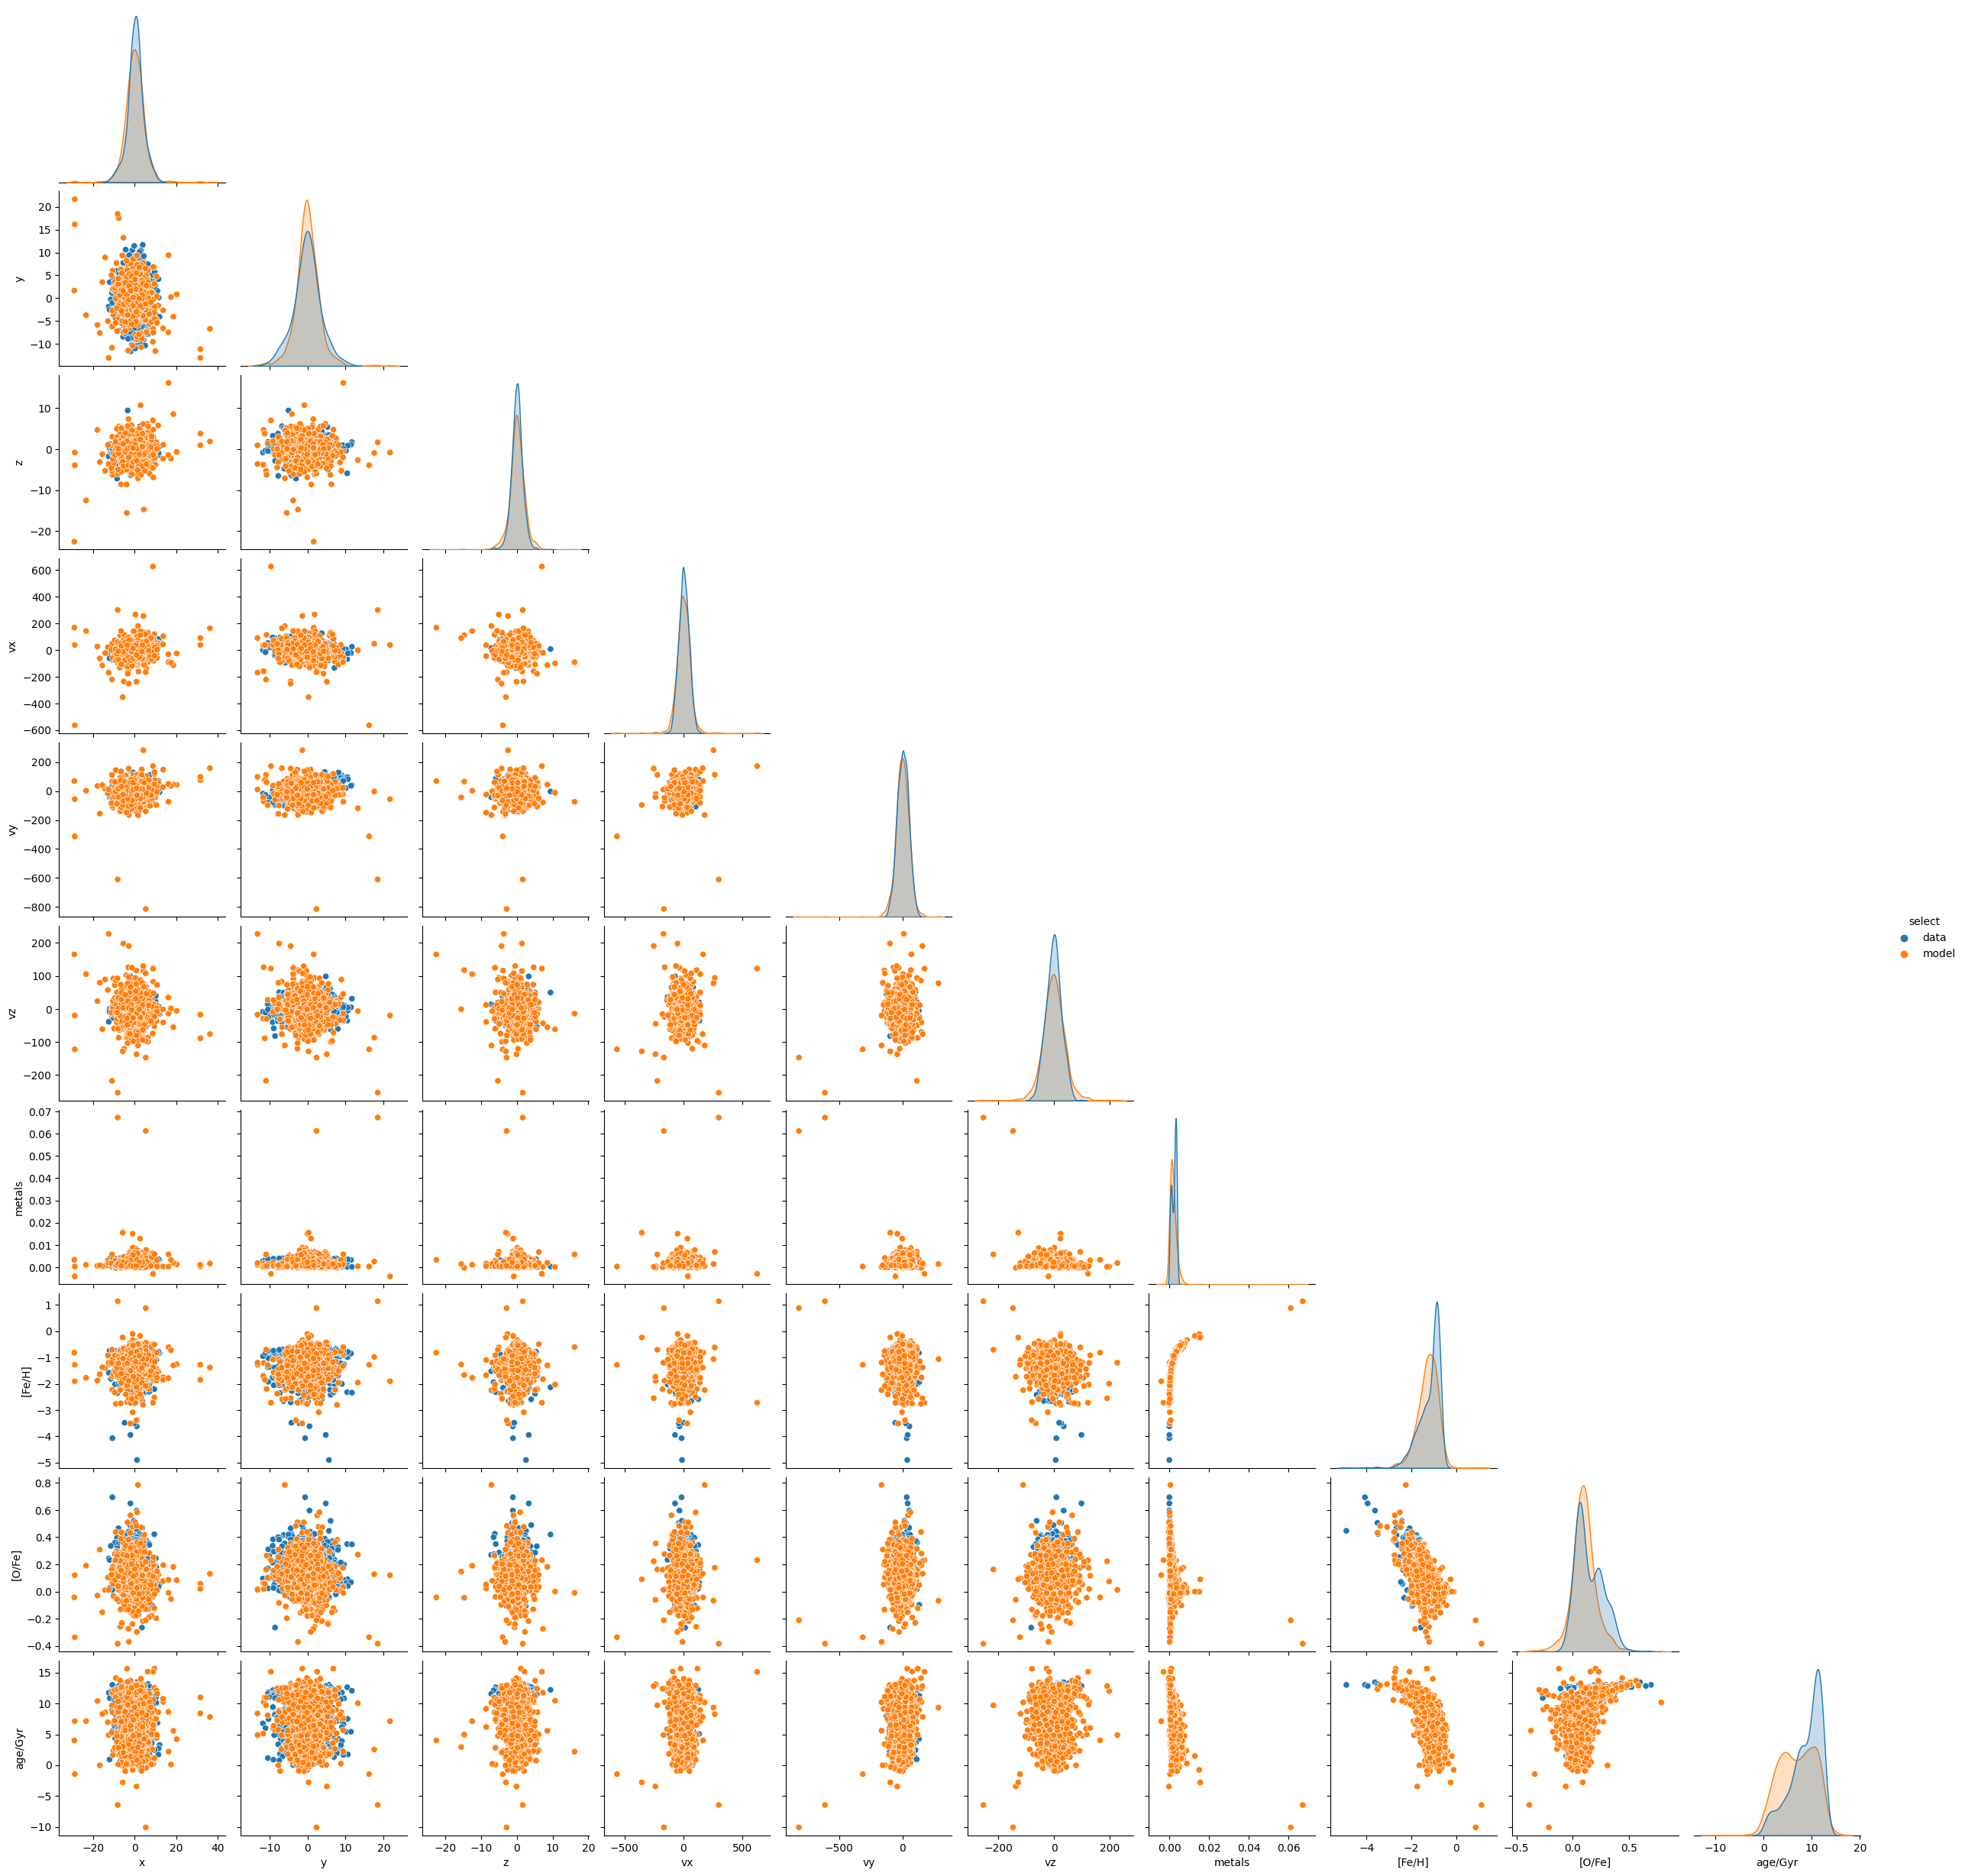

In [18]:
#Get comparison plot of single galaxy

visual.get_result_plots(Data_const[2], flow_sample[2], label=filename)

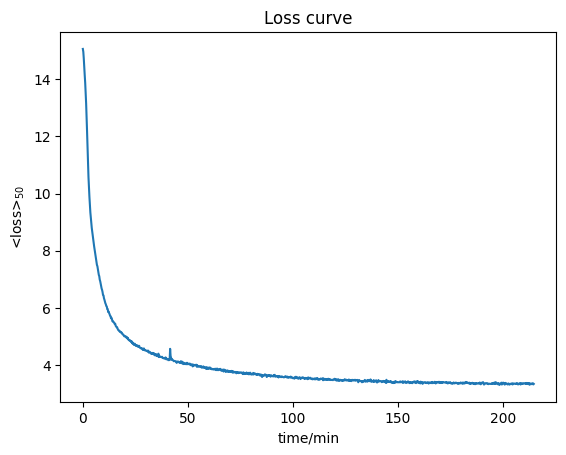

In [19]:
visual.loss_plot(loss_results, tot_time=tot_time, savefig=filename)